In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
import flopy
import flopy.utils.binaryfile as bf


In [3]:
## Set up directory referencing
# Package data
gwfm_dir = os.path.dirname(os.path.dirname(os.getcwd()))

## Plotting head raster and contours

In [4]:
# save modflow workspace file to WRDAPP sub folder to improve runtime calculations
loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/Cosumnes_Blodgett_10yr/'

# model_ws = loadpth+'WEL_SFR_RCH_layercake'
model_ws = loadpth+'LGR_SFR'

# loadpth = 'D:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_scenarios/Cosumnes/'
# runs = os.listdir(loadpth)[1:]
# model_ws = loadpth + runs[0]
name = 'MF.nam'
# name = 'MF_child.nam'
m = flopy.modflow.Modflow.load(name, model_ws=model_ws, 
                                exe_name='mf2005', version='mf2005')


In [5]:
def plot_head(model, hdobj, cbb, spd_stp,time, name, ax, hk):
    head = hdobj.get_data(kstpkper = spd_stp)
    levels_hmax = np.round(np.max(head[head!=1E+30]),-1)
#     levels_hmin = np.round(np.min(head[head!=-999.99]),-1)
    levels_hmin = np.round(np.min(head[head>=-200]),-1)
#     frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
#     fff = cbb.get_data(text='FLOW FRONT FACE')[0]
    levels = np.arange(levels_hmin, levels_hmax, 5)

    ax.set_title(name+' Head Contours at '+ str(time))
    mapview = flopy.plot.PlotMapView(model=model,ax=ax)
    
    contour_set = mapview.contour_array(head, masked_values=[-999.99], levels=levels, ax=ax)
    hcb = plt.colorbar(contour_set, shrink = 0.5,ax=ax)
    hcb.set_label('Head (m)')
#     ax.clabel(contour_set, contour_set.levels[0::2], inline=True, fontsize=8)

    # plot the horizontal hydraulic conductivities
    if hk == True:
        a = model.lpf.hk.array
        csa = mapview.plot_array(a, norm=mpl.colors.LogNorm())
        cb = plt.colorbar(csa, shrink=0.75,ax=ax)
        cb.set_label('Horiz. Cond. (m/d)')
    line = mapview.plot_bc('SFR', plotAll=True)
    mapview.plot_bc("GHB", plotAll=True)
    mapview.plot_bc("CHD", plotAll=True)
    mapview.plot_bc("WEL", plotAll=True)
#     mapview.plot_bc("LAK", plotAll=True)

#     quiver = mapview.plot_discharge(frf, fff, istep=10, jstep=10)  # no head array for volumetric discharge

    ax.ticklabel_format(style='plain')
    linecollection = mapview.plot_grid(linewidths = 0.3)
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
#     plt.savefig('Plots//'+name +'_head_contour.png', dpi = 600, bbox_inches='tight')

In [6]:
# cbb = flopy.utils.CellBudgetFile(model_ws+'/MF.upw.cbc')
cbb = flopy.utils.CellBudgetFile(model_ws+'/MF.cbc')

hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()


In [7]:
# create dates to match totim
# strt_date = pd.to_datetime(m.dis.start_datetime)
# end_date = strt_date+pd.DateOffset(months=m.dis.nper-1)
# dates = strt_date+pd.to_timedelta(zb_df.index-1, unit = 'days')

In [8]:
# create dataframe referencing between date, totim and kstp,kper
# time_spd = pd.DataFrame(np.transpose(np.array([times,spd_stp],dtype='object')),columns = ['totim','spd_stp'])
# time_spd.index = dates
# time_spd.totim = pd.to_numeric(time_spd.totim)

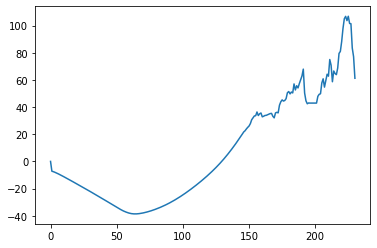

In [9]:
temp=m.ghb.stress_period_data[0]
plt.plot(temp[(temp.i==99)*(temp.k==1)].bhead)

ValueError: could not broadcast input array from shape (64,64) into shape (100,230)

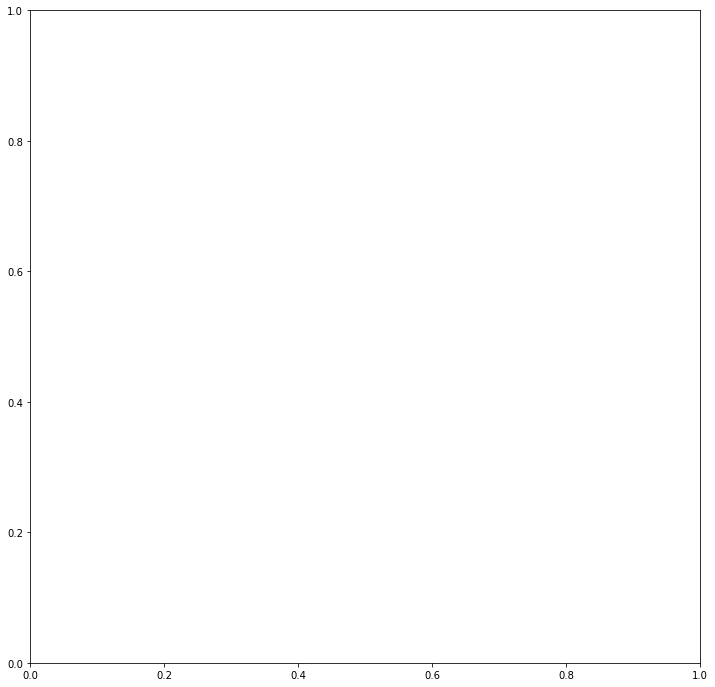

In [18]:
fig,ax = plt.subplots(figsize=(12,12))

plot_head(m, hdobj, cbb, spd_stp[0], 'steady state', 'MF',ax=ax,hk=False)

## SFR Last segment routing
Flow out of the last reach of a segment is saved and
used as inflow to the next downstream segment, or it is allowed
to the leave the modeled area if the last reach in the segment
exits the modeled area or if the segment is not connected to any
other segments (for example, if all the water is routed into a
lined canal or sealed pipeline).

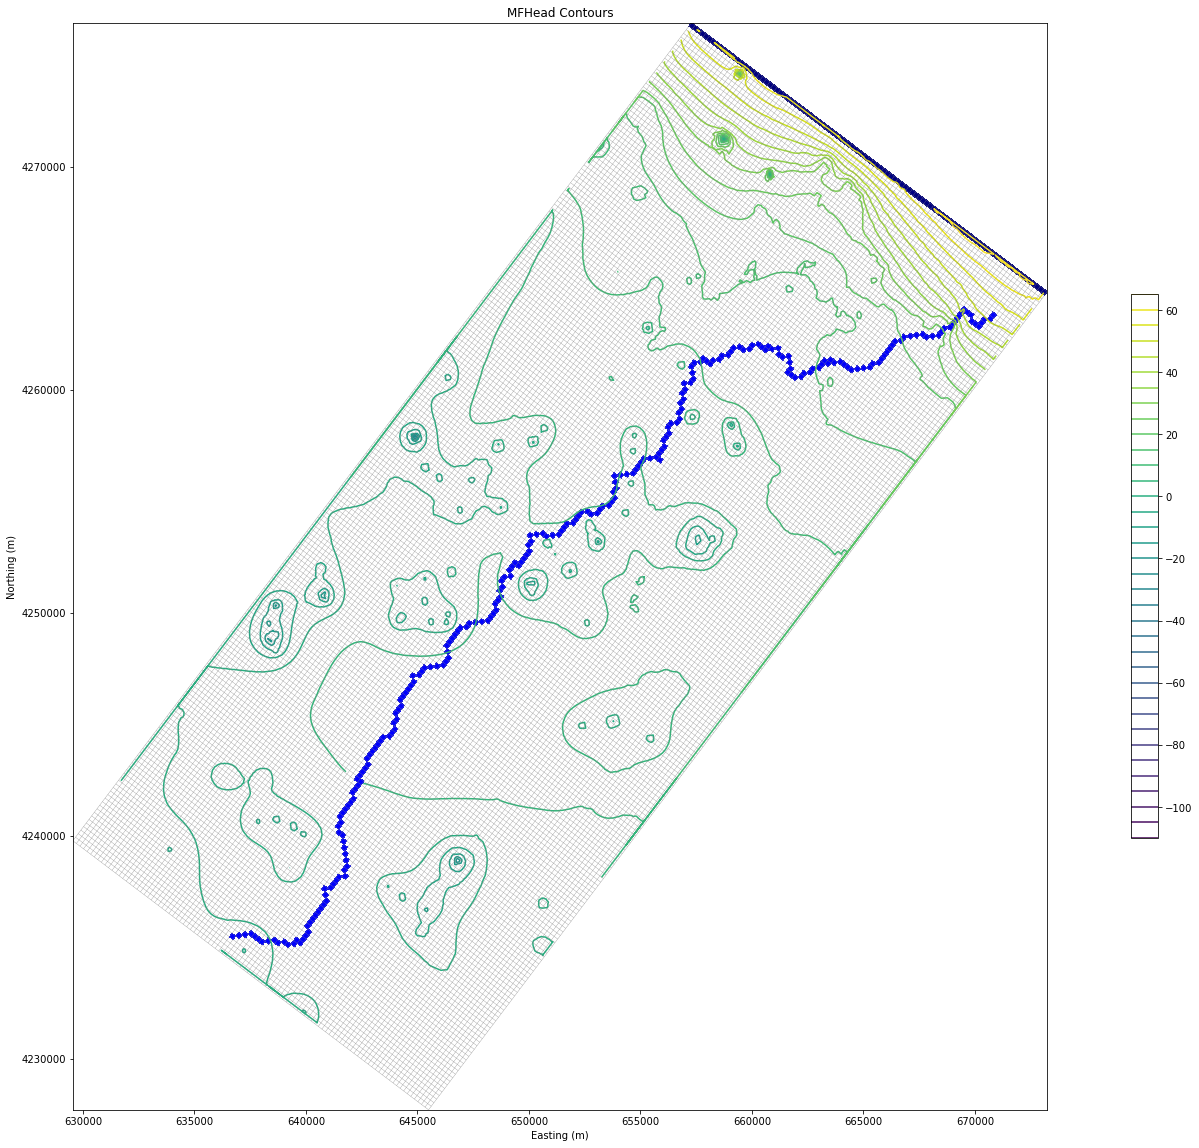

In [21]:
# for i in np.arange(0,len(spd_stp)):
plot_head(hdobj, cbb_upw, spd_stp[15], 'MF')

## Plot model cross section

In [40]:

def plot_xs(hdobj, spd_stp, name, col_row, num):
    head = hdobj.get_data(kstpkper = spd_stp)
    fig = plt.figure(figsize=(40, 20))
    ax = fig.add_subplot(1, 1, 1)
    col_rownum = num
    mcs = flopy.plot.PlotCrossSection(model=m, line={col_row : col_rownum})
    linecollection = mcs.plot_grid()
    mcs.plot_ibound(color_ch = 'yellow', color_noflow = 'black')
    ghbline = mcs.plot_bc('GHB')
#     wt = mcs.plot_surface(head, masked_values = [-999.99], color = 'blue', lw = 2.5)
    mcs.plot_bc("CHD")

    for k in np.arange(0,head.shape[0]):
        wt = mcs.plot_surface(head[k,:,:], masked_values = [-999.99], label = 'Layer'+str(k), lw = 2.5)
    

    
    # plot the horizontal hydraulic conductivities
#     a = m.upw.hk.array
    a = m.lpf.hk.array
    csa = mcs.plot_array(a, norm = mpl.colors.LogNorm())
    cb = plt.colorbar(csa, shrink=0.75)
    cb.set_label('Horiz. Cond. (m/month)')

    plt.ylabel('Elevation AMSL (m) ')
    plt.xlabel('Distance from West Model Boundary (m)')
    plt.legend(loc = (0.05,.7), prop={'size': 20})

    t = ax.set_title(name+'Row '+str(col_rownum)+' Cross-Section - with IBOUND Boundary Conditions')
#     plt.savefig('Plots//'+name +'_xs_row_'+str(rownum)+'.png', bbox_inches='tight')


In [18]:
hdobj.get_data(kstpkper = (0,0)).shape[0]

3

In [12]:
# head = hdobj.get_data(kstpkper = spd_stp[1])
# plt.imshow(head[0,:,:], vmin = -10, vmax = 70)
# plt.colorbar()
# np.savetxt('model_heads_after_sp6_use_for_strt_heads.tsv', head[0,:,:], delimiter = '\t')

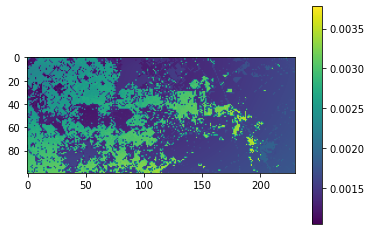

In [33]:
rch_plt = m.rch.rech.array[-1,0,:,:]
plt.imshow(rch_plt)
plt.colorbar()

In [28]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
print(spd_stp)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55)]


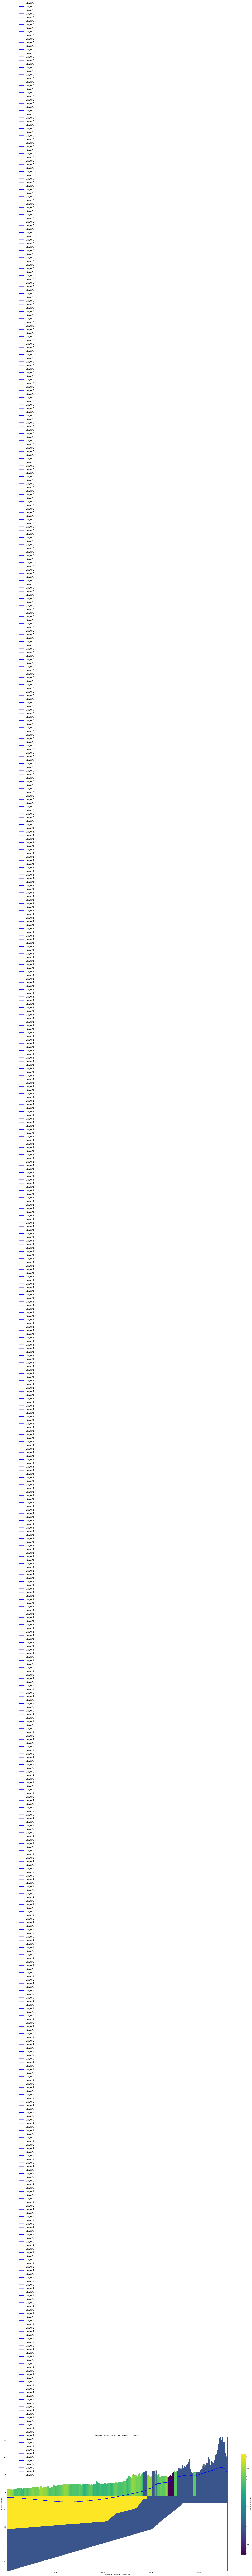

In [41]:
plot_xs(hdobj, spd_stp[54], 'MF', 'Row', 99)


## UZF plotting

## SFR specific plotting

In [16]:
loadpth = 'C://WRDAPP/GWFlowModel'
# loads very slowly
model_ws = loadpth+'/Cosumnes_simple/WEL_SFR_RCH_layercake'

# model_ws = loadpth+'/ButteValley_tr_parallel'

# model_ws = loadpth+'/ButteValley_tr'

# m = flopy.modflow.Modflow.load('MF.nam', model_ws=model_ws, 
#                                 exe_name='mf2005', version='mf2005')

In [17]:
cbb_str = flopy.utils.CellBudgetFile(model_ws+'/MF.cbc')
cbb_str.list_unique_records()


RECORD           IMETH
----------------------
STREAM LEAKAGE       5


In [7]:
sfr_dir = gwfm_dir+'/SFR_data'
str_leak = cbb_str.get_data(text='  STREAM LEAKAGE')[0]
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
str_leak = pd.DataFrame(str_leak)


In [24]:
# plot_sfr('MF')
sfrout = flopy.utils.SfrFile(model_ws+'/MF.sfr.out')
# sfrdf = sfrout.get_dataframe()
# # create tuple of segment and reach for plotting
# sfrdf['seg_reach'] = list(zip(sfrdf.segment, sfrdf.reach)) 

# plot_step = sfrdf.kstpkper.unique()
# len(plot_step)

In [25]:
sfrout.get_dataframe()

IndexError: pop from empty list

In [21]:
sfr_times = sfrout.get_times()


Index(['node', 'row', 'column', 'index_righ', 'z', 'easting', 'northing',
       'slope', 'Point_orde', 'length_m', 'reach', 'geometry', 'layer', 'row',
       'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout', 'Qovr',
       'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'kstpkper', 'k', 'i', 'j', 'seg_reach'],
      dtype='object')


C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


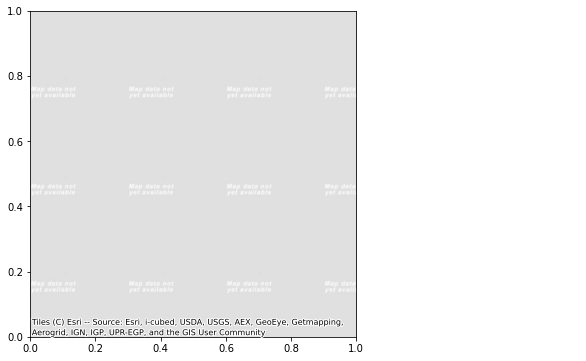

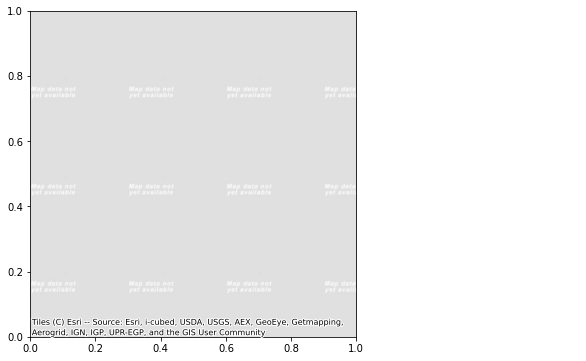

In [131]:
grid_sfr
df = sfrdf[sfrdf.kstpkper == plot_step[36]]

df.index= np.arange(0,len(df))
sfrout_gdf = pd.concat([grid_sfr, df],axis=1)
print(sfrout_gdf.columns)

fig,ax = plt.subplots(figsize=(6,6))
sfrout_gdf['reach_num_all'] = np.arange(1,len(sfrout_gdf)+1)

sfrout_gdf.loc[sfrout_gdf.segment>27].plot('segment',legend = True,ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldImagery, crs='epsg:26910', alpha = 0.6)


fig,ax = plt.subplots(figsize=(6,6))
sfrout_gdf['reach_num_all'] = np.arange(1,len(sfrout_gdf)+1)

sfrout_gdf.loc[sfrout_gdf.segment>27].plot('reach_num_all',legend = True,ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldImagery, crs='epsg:26910', alpha = 0.6)

In [229]:
sfrdfCond

NameError: name 'sfrdfCond' is not defined

Number of stress periods saved: 557


C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


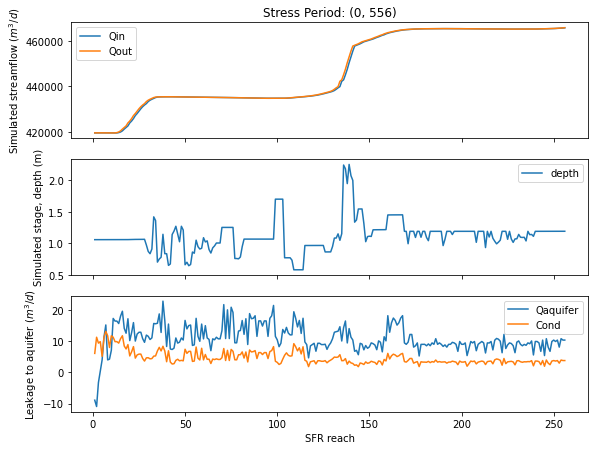

In [251]:

def plot_sf_leak(df, sp_ts):
    df = df[df.kstpkper == sp_ts]
    # add reach length and reach number from 1 to total reaches for easier plotting
    df['length_m'] = grid_sfr.length_m.values
    df['reach_num_all'] = grid_sfr.reach.values
    
    df = df.loc[df.reach_num_all>0]
#     df = df.loc[df.reach_num_all<340]

    fig, axes = plt.subplots(3, 1, sharex=True, figsize = (8,6))
    fig.tight_layout()

    ax = df.plot(x='reach_num_all',y=['Qin', 'Qout'],ax = axes[0])
    ax1 = df.plot(x='reach_num_all',y=[ 'depth'],ax = axes[1])
    
    ax.set_title('Stress Period: '+ str(sp_ts))

    ax.set_ylabel('Simulated streamflow ($m^3/d$)')
    ax1.set_ylabel('Simulated stage, depth (m)')

    ax = df.plot(x='reach_num_all',y=['Qaquifer','Cond'],ax = axes[2])
    axes[2].set_ylabel('Leakage to aquifer ($m^3/d$)');
    axes[2].set_xlabel('SFR reach');
    plt.savefig('Plots/problem_reach_flow_jump.png', bbox_inches = 'tight', dpi = 600)
print('Number of stress periods saved:', len(plot_step))
i = len(plot_step)-1
sfrdf
plot_sf_leak(sfrdf, plot_step[i])


In [188]:
grid_sfr.loc[grid_sfr.reach==331]

node   row  column  index_righ         z        easting      northing  \
330  12208  54.0    18.0      5631.0  1.749855  640158.164384  4.236124e+06   

        slope  Point_orde  length_m  reach  \
330  0.000381      5631.0       210    331   

                                              geometry  
330  POLYGON ((640053.618 4236081.941, 640174.260 4...

In [189]:
sfrdf.loc[0:358].loc[sfrdf[0:358].row==54.0]

layer  row  column  segment  reach        Qin  Qaquifer       Qout  Qovr  \
95      11   54     179       12      7  1673700.0    65.937  1673600.0   0.0   
144     11   54     149       17      3  1660600.0   181.190  1660500.0   0.0   
145     11   54     148       17      4  1660500.0  1434.500  1659000.0   0.0   
313     11   54      31       30     22  1535400.0   972.800  1534400.0   0.0   
323     11   54      25       30     32  1531300.0   453.690  1530900.0   0.0   
324     11   54      24       30     33  1530900.0   460.130  1530400.0   0.0   
325     11   54      23       30     34  1530400.0   423.520  1530000.0   0.0   
326     11   54      22       30     35  1530000.0   444.370  1529600.0   0.0   
327     11   54      21       30     36  1529600.0   402.410  1529200.0   0.0   
328     11   54      20       30     37  1529200.0   292.060  1528900.0   0.0   
329     11   54      19       30     38  1528900.0   415.220  1528500.0   0.0   
330     11   54      18       30     39  1528500.0   331.010  1528100.0   0.0   
331     11   54      17       30     40  1528100.0   302.190  1527800.0   0.0   
332     11   54      16       30     41  1527800.0   164.710  1527700.0   0.0   
337     11   54      13       30     46  1526300.0   160.680  1526100.0   0.0   
338     11   54      12       30     47  1526100.0   300.140  1525800.0   0.0   

     Qprecip  ...     stage  depth  width    Cond  gradient  kstpkper   k   i  \
95       0.0  ...  27.68730  1.791  35.81  5853.0  0.005633    (0, 0)  10  53   
144      0.0  ...  24.66800  2.717  34.49   165.8  0.546400    (0, 0)  10  53   
145      0.0  ...  24.64360  2.717  34.49  2487.0  0.288400    (0, 0)  10  53   
313      0.0  ...   4.95245  1.988  27.99  2333.0  0.208400    (0, 0)  10  53   
323      0.0  ...   3.85230  1.986  27.99  1235.0  0.183700    (0, 0)  10  53   
324      0.0  ...   3.64663  1.887  27.61  3109.0  0.074000    (0, 0)  10  53   
325      0.0  ...   3.42824  1.798  27.26  2800.0  0.075630    (0, 0)  10  53   
326      0.0  ...   3.31537  1.791  27.23  2663.0  0.083420    (0, 0)  10  53   
327      0.0  ...   3.05277  1.798  27.26  2800.0  0.071870    (0, 0)  10  53   
328      0.0  ...   2.71900  1.680  26.81  2748.0  0.053130    (0, 0)  10  53   
329      0.0  ...   2.82227  1.984  27.98  2881.0  0.072060    (0, 0)  10  53   
330      0.0  ...   2.62754  1.878  27.57  2834.0  0.058390    (0, 0)  10  53   
331      0.0  ...   2.47268  1.886  27.60  3108.0  0.048610    (0, 0)  10  53   
332      0.0  ...   2.31433  1.790  27.23  1331.0  0.061850    (0, 0)  10  53   
337      0.0  ...   2.23146  1.983  27.97  2057.0  0.039050    (0, 0)  10  53   
338      0.0  ...   2.17432  1.983  27.97  3155.0  0.047570    (0, 0)  10  53   

       j  seg_reach  
95   178    (12, 7)  
144  148    (17, 3)  
145  147    (17, 4)  
313   30   (30, 22)  
323   24   (30, 32)  
324   23   (30, 33)  
325   22   (30, 34)  
326   21   (30, 35)  
327   20   (30, 36)  
328   19   (30, 37)  
329   18   (30, 38)  
330   17   (30, 39)  
331   16   (30, 40)  
332   15   (30, 41)  
337   12   (30, 46)  
338   11   (30, 47)  

[16 rows x 21 columns]

In [190]:
df.loc[df.segment>28].iloc[50:70]

layer  row  column  segment  reach      Qin  Qaquifer      Qout  Qovr  \
290     11   44      46       29     51  58012.0   277.120   58017.0   0.0   
291     11   45      45       29     52  58017.0   662.570   57660.0   0.0   
292     11   45      44       30      1  57660.0   653.150   56937.0   0.0   
293     11   45      43       30      2  56937.0   686.900   56743.0   0.0   
294     11   45      42       30      3  56743.0   839.270   55884.0   0.0   
295     11   45      41       30      4  55884.0   423.650   55438.0   0.0   
296     11   46      41       30      5  55438.0   167.020   55300.0   0.0   
297     11   46      40       30      6  55300.0   497.130   55328.0   0.0   
298     11   46      39       30      7  55328.0   329.300   57414.0   0.0   
299     11   46      38       30      8  57414.0   475.400   49918.0   0.0   
300     11   47      38       30      9  49918.0   500.670   16493.0   0.0   
301     11   48      38       30     10  16493.0   343.650   59069.0   0.0   
302     11   48      37       30     11  59069.0   193.100   59810.0   0.0   
303     11   49      37       30     12  59810.0   424.490   57565.0   0.0   
304     11   49      36       30     13  57565.0   296.300   57279.0   0.0   
305     11   50      36       30     14  57279.0   486.700   57133.0   0.0   
306     11   50      35       30     15  57133.0   178.080   57006.0   0.0   
307     11   51      35       30     16  57006.0   513.690   57475.0   0.0   
308     11   51      34       30     17  57475.0    91.573   56048.0   0.0   
309     11   52      34       30     18  56048.0   484.340  111800.0   0.0   

     Qprecip  ...    stage   depth   width    Cond  gradient  kstpkper   k  \
290      0.0  ...  6.57011  0.6340  22.770   436.7    0.3173  (0, 180)  10   
291      0.0  ...  6.53294  0.6330  22.770  2183.0    0.1517  (0, 180)  10   
292      0.0  ...  6.47042  0.6320  22.760  2292.0    0.1425  (0, 180)  10   
293      0.0  ...  6.40466  0.6307  22.760  2400.0    0.1431  (0, 180)  10   
294      0.0  ...  6.33857  0.6295  22.750  2291.0    0.1832  (0, 180)  10   
295      0.0  ...  5.66358  0.4287   9.133   701.6    0.3019  (0, 180)  10   
296      0.0  ...  5.03905  0.6281  22.750   436.2    0.1914  (0, 180)  10   
297      0.0  ...  5.00088  0.6274  22.750  2290.0    0.1085  (0, 180)  10   
298      0.0  ...  4.91419  0.5175  10.210  1082.0    0.1522  (0, 180)  10   
299      0.0  ...  4.34132  0.6262  22.740   872.2    0.2725  (0, 180)  10   
300      0.0  ...  4.84181  0.6250  22.740  2398.0    0.1044  (0, 180)  10   
301      0.0  ...  4.77109  0.5027  10.030   820.6    0.2094  (0, 180)  10   
302      0.0  ...  4.60299  0.4993   9.983   384.5    0.2511  (0, 180)  10   
303      0.0  ...  4.46076  0.4748   9.710  1165.0    0.1822  (0, 180)  10   
304      0.0  ...  4.50722  0.6229  22.730   435.8    0.3399  (0, 180)  10   
305      0.0  ...  4.18265  0.4536   9.511  1224.0    0.1988  (0, 180)  10   
306      0.0  ...  4.21911  0.6269  22.750   218.1    0.4083  (0, 180)  10   
307      0.0  ...  3.93103  0.4732   9.788  1209.0    0.2124  (0, 180)  10   
308      0.0  ...  3.80712  0.4601   9.524   137.2    0.3338  (0, 180)  10   
309      0.0  ...  3.81144  0.4991  22.660  1153.0    0.2099  (0, 180)  10   

      i   j  seg_reach  
290  43  45   (29, 51)  
291  44  44   (29, 52)  
292  44  43    (30, 1)  
293  44  42    (30, 2)  
294  44  41    (30, 3)  
295  44  40    (30, 4)  
296  45  40    (30, 5)  
297  45  39    (30, 6)  
298  45  38    (30, 7)  
299  45  37    (30, 8)  
300  46  37    (30, 9)  
301  47  37   (30, 10)  
302  47  36   (30, 11)  
303  48  36   (30, 12)  
304  48  35   (30, 13)  
305  49  35   (30, 14)  
306  49  34   (30, 15)  
307  50  34   (30, 16)  
308  50  33   (30, 17)  
309  51  33   (30, 18)  

[20 rows x 21 columns]

Number of stress periods saved: 557


C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


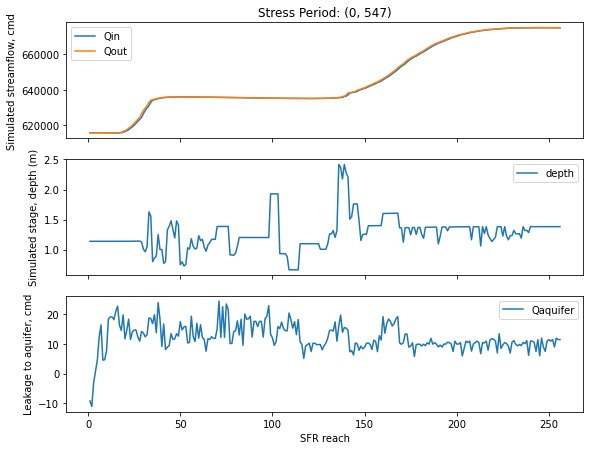

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


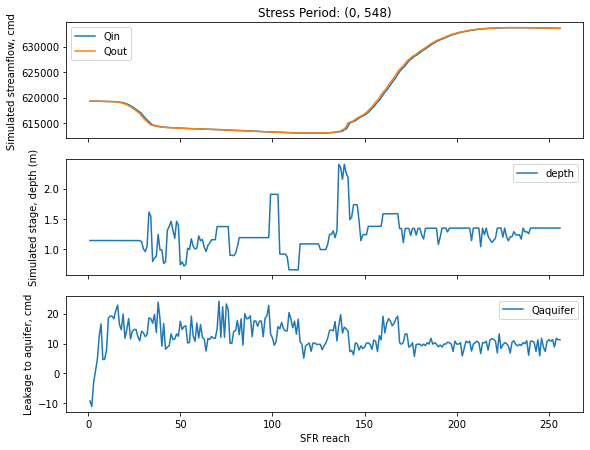

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


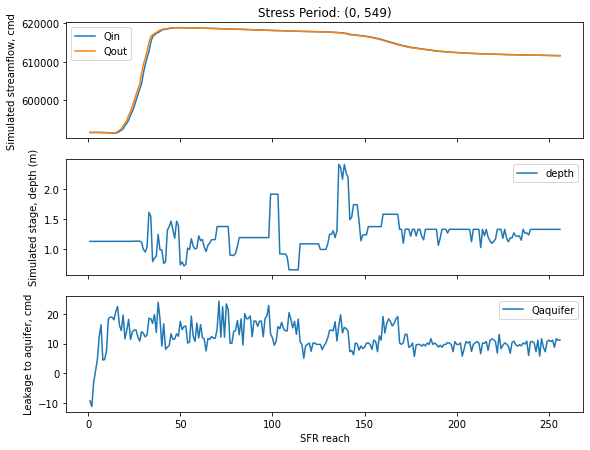

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


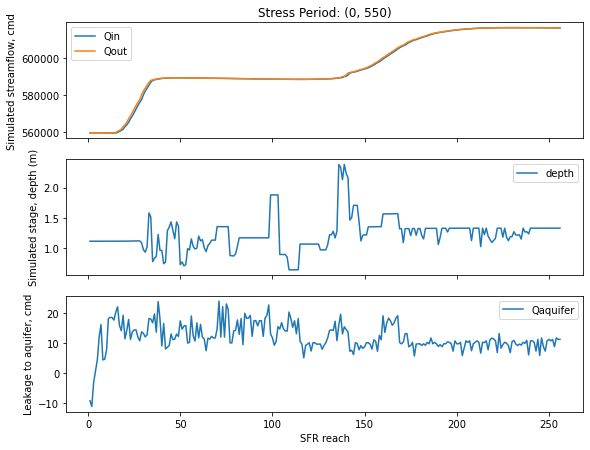

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


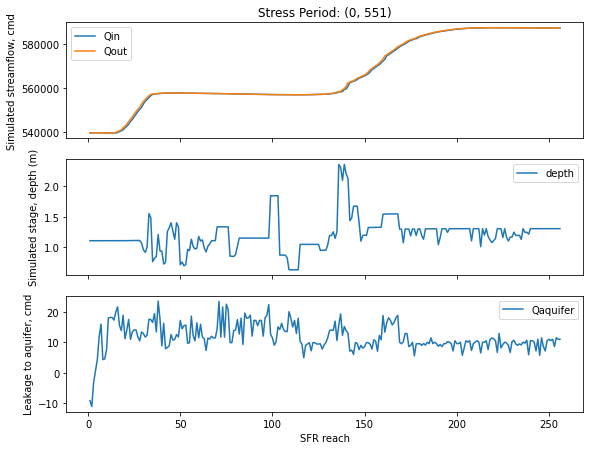

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


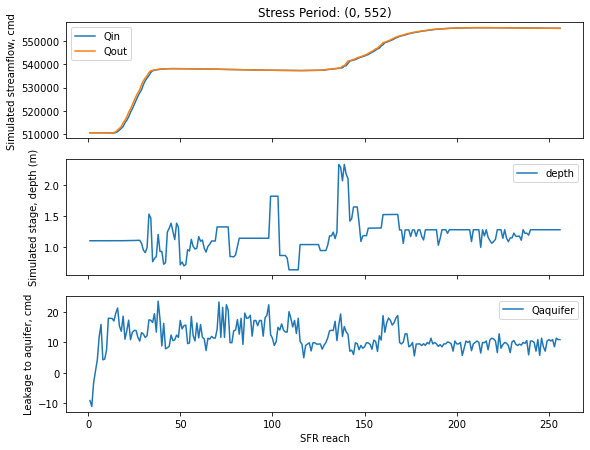

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


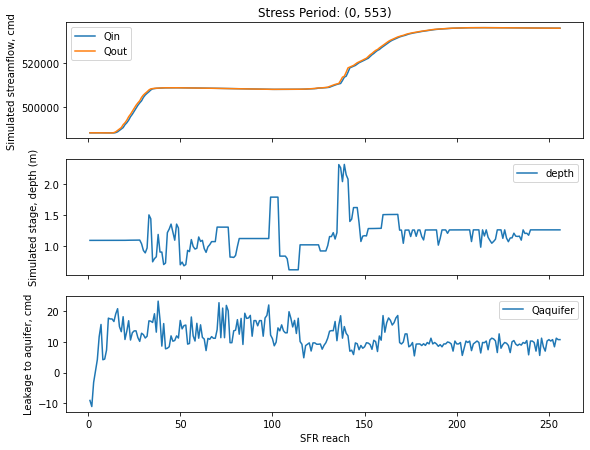

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


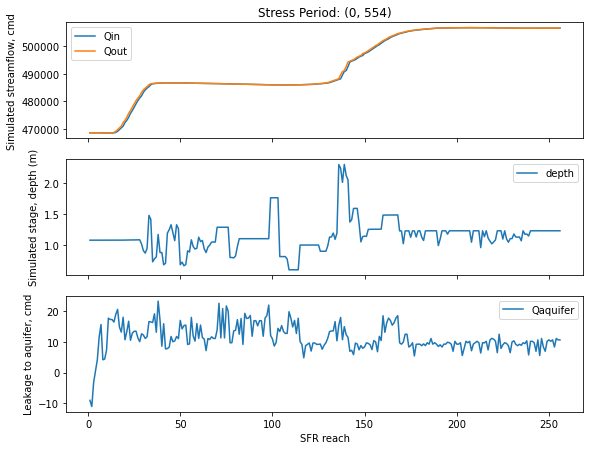

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


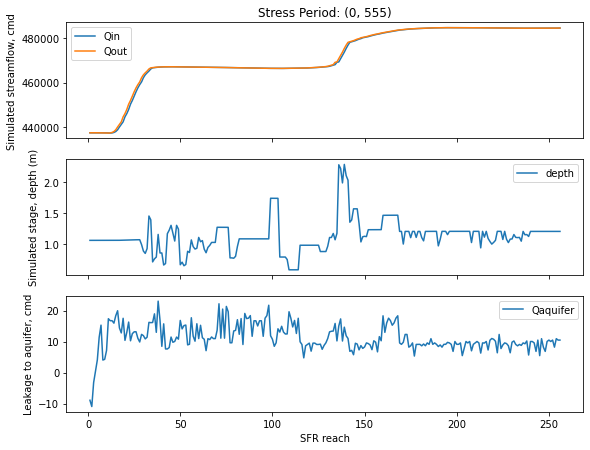

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


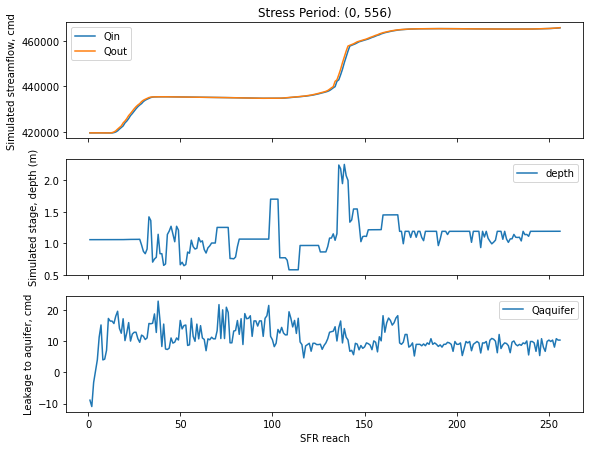

In [252]:

def plot_sf_leak(df, sp_ts):
    df = df.loc[df.kstpkper == sp_ts]
    # add reach length and reach number from 1 to total reaches for easier plotting
    df['length_m'] = grid_sfr.length_m.values
    df['reach_num_all'] = grid_sfr.reach.values
    
    fig, axes = plt.subplots(3, 1, sharex=True, figsize = (8,6))
    fig.tight_layout()

    ax = df.plot(x='reach_num_all',y=['Qin', 'Qout'],ax = axes[0])
    ax1 = df.plot(x='reach_num_all',y=['depth'],ax = axes[1])


    ax.set_title('Stress Period: '+ str(sp_ts))
    ax1.set_ylabel('Simulated stage, depth (m)')

    ax.set_ylabel('Simulated streamflow, cmd')

    ax = df.plot(x='reach_num_all',y='Qaquifer',ax = axes[2])
    axes[2].set_ylabel('Leakage to aquifer, cmd');
    axes[2].set_xlabel('SFR reach');
    plt.show()
print('Number of stress periods saved:', len(plot_step))
for i in np.arange(len(plot_step)-10,len(plot_step)):
    plot_sf_leak(sfrdf, plot_step[i])


In [254]:
sfrdf.seg_reach.unique()

array([(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8),
       (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15),
       (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22),
       (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (2, 1),
       (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (4, 1), (4, 2), (4, 3),
       (5, 1), (6, 1), (6, 2), (6, 3), (6, 4), (7, 1), (7, 2), (7, 3),
       (7, 4), (7, 5), (7, 6), (7, 7), (8, 1), (8, 2), (8, 3), (8, 4),
       (9, 1), (9, 2), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5),
       (10, 6), (10, 7), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5),
       (11, 6), (11, 7), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5),
       (12, 6), (12, 7), (13, 1), (13, 2), (13, 3), (13, 4), (14, 1),
       (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (14, 8),
       (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14),
       (14, 15), (14, 16), (14, 17), (14, 18), (15, 1), (15, 2), (15, 3),
       (15, 4), (15,

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


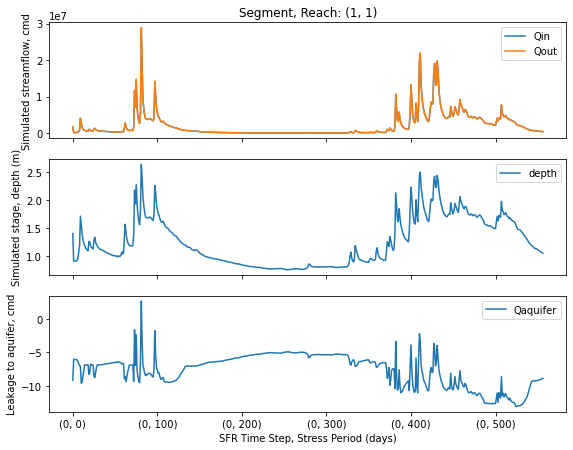

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


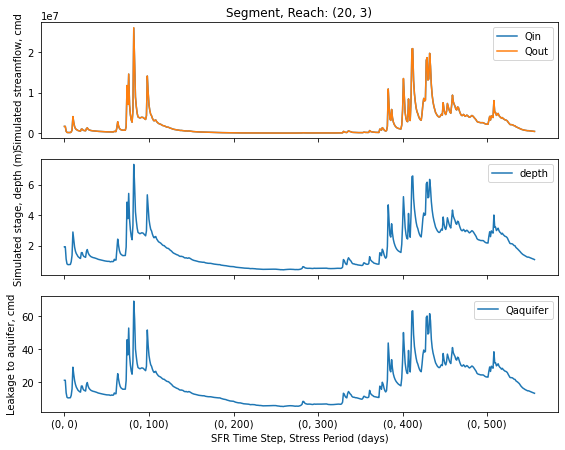

C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


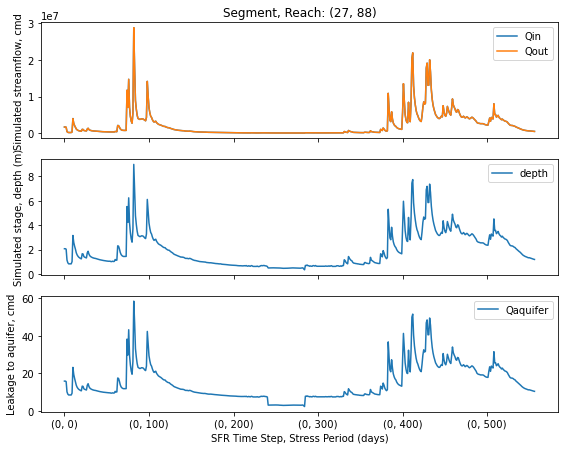

In [255]:
def plot_sf_timeseries(df, seg_reach):
    df = df.loc[df.seg_reach == seg_reach]

    fig, axes = plt.subplots(3, 1, sharex=True, figsize = (8,6))
    fig.tight_layout()

    ax = df.plot(x='kstpkper',y=['Qin', 'Qout'],ax = axes[0])
    ax.set_title('Segment, Reach: '+ str(seg_reach))
    ax.set_ylabel('Simulated streamflow, cmd')

    ax1 = df.plot(x='kstpkper',y=['depth'],ax = axes[1])
    ax1.set_ylabel('Simulated stage, depth (m)')
    ax = df.plot(x='kstpkper',y='Qaquifer',ax = axes[2])
    axes[2].set_ylabel('Leakage to aquifer, cmd');
    
    axes[2].set_xlabel('SFR Time Step, Stress Period (days)');
    plt.show()
    
plot_sf_timeseries(sfrdf, seg_reach = (1,1))
plot_sf_timeseries(sfrdf, seg_reach = (20,3))
plot_sf_timeseries(sfrdf, seg_reach = (27,88))

In [62]:
strt_date = pd.to_datetime(m.dis.start_datetime)
end_date = strt_date + pd.DateOffset(days=m.dis.nper-2)

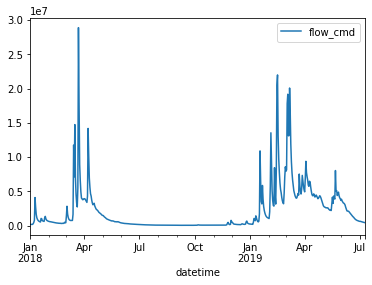

The flow in stress period (0,0) is the mean flow of the whole period, designed to account for the steady state period


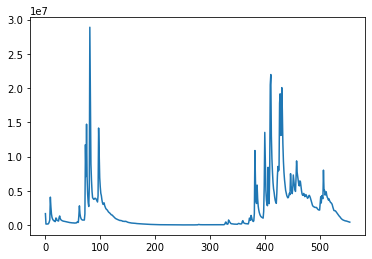

In [256]:
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'/MB_daily_flow_cfs_2011_2019.csv', index_col = 'datetime', parse_dates = True)

# filter out data between the stress period dates
inflow = inflow.loc[strt_date:end_date]
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))
# # # np.arange(0,len(flow_cmd))
time_flow = np.vstack((np.arange(1,len(inflow.flow_cmd)+1),inflow.flow_cmd))
time_flow = np.transpose(time_flow)
# add a first row to account for the steady state stress period
time_flow = np.row_stack(([0, inflow.flow_cmd.mean()], time_flow))

# find last stress period to filter data
final_spd = sfrdf.kstpkper.unique()[-1][1]
t = final_spd
inflow.iloc[0:t,:].plot(y='flow_cmd')
plt.show()
plt.plot(time_flow[0:t,0],time_flow[0:t,1])
print('The flow in stress period (0,0) is the mean flow of the whole period, designed to account for the steady state period')

Text(0, 0.5, 'Difference between input and simulated streamflow')

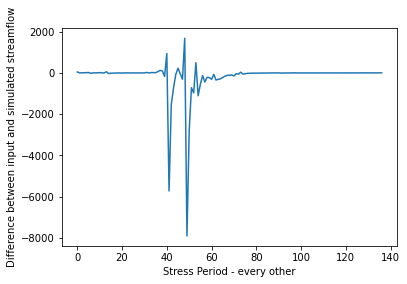

In [169]:
temp = sfrdf.loc[sfrdf.seg_reach == (1,1)]
# take the difference between every other timestep input and simulated streamflow
plt.plot(time_flow[0:t+1:2,1]-temp.Qin.values)
plt.xlabel('Stress Period - every other')
plt.ylabel('Difference between input and simulated streamflow')

In [94]:
sfrdf.loc[sfrdf.seg_reach == (1,1)]


layer  row  column  segment  reach        Qin  Qaquifer       Qout  \
0         11   95     219        1      1  1680300.0   -31.475  1680400.0   
361       11   95     219        1      1   157190.0   -38.118   157230.0   
722       11   95     219        1      1   166490.0   -37.416   166530.0   
1083      11   95     219        1      1   279120.0   -35.595   279160.0   
1444      11   95     219        1      1   776150.0   -30.659   776180.0   
1805      11   95     219        1      1  2668800.0   -33.496  2668800.0   
2166      11   95     219        1      1  1141000.0   -36.134  1141000.0   
2527      11   95     219        1      1   761470.0   -35.076   761500.0   
2888      11   95     219        1      1   599870.0   -35.741   599900.0   
3249      11   95     219        1      1   519070.0   -35.688   519110.0   
3610      11   95     219        1      1  1006300.0   -33.467  1006300.0   
3971      11   95     219        1      1   668430.0   -35.141   668460.0   
4332      11   95     219        1      1   599870.0   -35.405   599910.0   
4693      11   95     219        1      1  1336800.0   -30.864  1336900.0   
5054      11   95     219        1      1   812920.0   -34.923   812950.0   
5415      11   95     219        1      1   673340.0   -35.061   673370.0   
5776      11   95     219        1      1   602330.0   -35.305   602360.0   
6137      11   95     219        1      1   568050.0   -35.221   568080.0   
6498      11   95     219        1      1   528870.0   -35.502   528910.0   
6859      11   95     219        1      1   479900.0   -35.847   479940.0   
7220      11   95     219        1      1   440730.0   -35.956   440760.0   
7581      11   95     219        1      1   411340.0   -36.184   411380.0   
7942      11   95     219        1      1   384410.0   -36.249   384450.0   
8303      11   95     219        1      1   357480.0   -36.488   357510.0   
8664      11   95     219        1      1   337890.0   -36.563   337930.0   
9025      11   95     219        1      1   330540.0   -36.480   330580.0   
9386      11   95     219        1      1   306060.0   -37.001   306100.0   
9747      11   95     219        1      1   332990.0   -36.056   333030.0   
10108     11   95     219        1      1   318300.0   -36.455   318340.0   
10469     11   95     219        1      1   475000.0   -34.252   475040.0   
10830     11   95     219        1      1   416240.0   -35.659   416280.0   
11191     11   95     219        1      1  2815700.0   -22.228  2815800.0   
11552     11   95     219        1      1  1197300.0   -35.681  1197300.0   
11913     11   95     219        1      1   830010.0   -34.644   830050.0   
12274     11   95     219        1      1   739420.0   -34.399   739460.0   
12635     11   95     219        1      1   744320.0   -34.070   744350.0   
12996     11   95     219        1      1  1645300.0   -25.802  1645400.0   
13357     11   95     219        1      1  7100400.0   -29.953  7100400.0   

       Qovr  Qprecip  ...    stage   depth  width    Cond  gradient  kstpkper  \
0       0.0      0.0  ...  53.4345  1.4090  62.18  1174.0 -0.013410    (0, 0)   
361     0.0      0.0  ...  52.9432  0.9174  22.63   427.1 -0.044620    (0, 2)   
722     0.0      0.0  ...  52.9495  0.9237  22.95   433.2 -0.043190    (0, 4)   
1083    0.0      0.0  ...  53.0056  0.9799  25.11   473.9 -0.037560    (0, 6)   
1444    0.0      0.0  ...  53.2280  1.2020  34.29   647.3 -0.023680    (0, 8)   
1805    0.0      0.0  ...  53.5842  1.5580  75.25  1420.0 -0.011790   (0, 10)   
2166    0.0      0.0  ...  53.3197  1.2940  48.57   916.8 -0.019710   (0, 12)   
2527    0.0      0.0  ...  53.2230  1.1970  33.70   636.1 -0.027570   (0, 14)   
2888    0.0      0.0  ...  53.1578  1.1320  31.61   596.7 -0.029950   (0, 16)   
3249    0.0      0.0  ...  53.1270  1.1010  30.40   573.8 -0.031100   (0, 18)   
3610    0.0      0.0  ...  53.2849  1.2590  44.38   837.6 -0.019980   (0, 20)   
3971    0.0      0.0  ...  53.1

In [71]:
time_flow

array([[0.00000000e+00, 1.68034682e+06],
       [1.00000000e+00, 1.59884143e+05],
       [2.00000000e+00, 1.57190842e+05],
       ...,
       [7.28000000e+02, 3.30541490e+05],
       [7.29000000e+02, 3.15850757e+05],
       [7.30000000e+02, 3.03608479e+05]])

In [26]:
sfrdf.loc[sfrdf.seg_reach == (1,1)]

layer  row  column  segment  reach        Qin  Qaquifer       Qout  \
0         11   95     219        1      1  1680300.0   -31.475  1680400.0   
361       11   95     219        1      1   157190.0   -38.118   157230.0   
722       11   95     219        1      1   166490.0   -37.416   166530.0   
1083      11   95     219        1      1   279120.0   -35.595   279160.0   
1444      11   95     219        1      1   776150.0   -30.659   776180.0   
1805      11   95     219        1      1  2668800.0   -33.496  2668800.0   
2166      11   95     219        1      1  1141000.0   -36.134  1141000.0   
2527      11   95     219        1      1   761470.0   -35.076   761500.0   
2888      11   95     219        1      1   599870.0   -35.741   599900.0   
3249      11   95     219        1      1   519070.0   -35.688   519110.0   
3610      11   95     219        1      1  1006300.0   -33.467  1006300.0   
3971      11   95     219        1      1   668430.0   -35.141   668460.0   
4332      11   95     219        1      1   599870.0   -35.405   599910.0   
4693      11   95     219        1      1  1336800.0   -30.864  1336900.0   
5054      11   95     219        1      1   812920.0   -34.923   812950.0   
5415      11   95     219        1      1   673340.0   -35.061   673370.0   
5776      11   95     219        1      1   602330.0   -35.305   602360.0   
6137      11   95     219        1      1   568050.0   -35.221   568080.0   
6498      11   95     219        1      1   528870.0   -35.502   528910.0   
6859      11   95     219        1      1   479900.0   -35.847   479940.0   
7220      11   95     219        1      1   440730.0   -35.956   440760.0   
7581      11   95     219        1      1   411340.0   -36.184   411380.0   
7942      11   95     219        1      1   384410.0   -36.249   384450.0   
8303      11   95     219        1      1   357480.0   -36.488   357510.0   
8664      11   95     219        1      1   337890.0   -36.563   337930.0   
9025      11   95     219        1      1   330540.0   -36.480   330580.0   
9386      11   95     219        1      1   306060.0   -37.001   306100.0   
9747      11   95     219        1      1   332990.0   -36.056   333030.0   
10108     11   95     219        1      1   318300.0   -36.455   318340.0   
10469     11   95     219        1      1   475000.0   -34.252   475040.0   
10830     11   95     219        1      1   416240.0   -35.659   416280.0   
11191     11   95     219        1      1  2815700.0   -22.228  2815800.0   
11552     11   95     219        1      1  1197300.0   -35.681  1197300.0   
11913     11   95     219        1      1   830010.0   -34.644   830050.0   
12274     11   95     219        1      1   739420.0   -34.399   739460.0   
12635     11   95     219        1      1   744320.0   -34.070   744350.0   
12996     11   95     219        1      1  1645300.0   -25.802  1645400.0   
13357     11   95     219        1      1  7100400.0   -29.953  7100400.0   

       Qovr  Qprecip  ...    stage   depth  width    Cond  gradient  kstpkper  \
0       0.0      0.0  ...  53.4345  1.4090  62.18  1174.0 -0.013410    (0, 0)   
361     0.0      0.0  ...  52.9432  0.9174  22.63   427.1 -0.044620    (0, 2)   
722     0.0      0.0  ...  52.9495  0.9237  22.95   433.2 -0.043190    (0, 4)   
1083    0.0      0.0  ...  53.0056  0.9799  25.11   473.9 -0.037560    (0, 6)   
1444    0.0      0.0  ...  53.2280  1.2020  34.29   647.3 -0.023680    (0, 8)   
1805    0.0      0.0  ...  53.5842  1.5580  75.25  1420.0 -0.011790   (0, 10)   
2166    0.0      0.0  ...  53.3197  1.2940  48.57   916.8 -0.019710   (0, 12)   
2527    0.0      0.0  ...  53.2230  1.1970  33.70   636.1 -0.027570   (0, 14)   
2888    0.0      0.0  ...  53.1578  1.1320  31.61   596.7 -0.029950   (0, 16)   
3249    0.0      0.0  ...  53.1270  1.1010  30.40   573.8 -0.031100   (0, 18)   
3610    0.0      0.0  ...  53.2849  1.2590  44.38   837.6 -0.019980   (0, 20)   
3971    0.0      0.0  ...  53.1

In [40]:
streambed_top = m.sfr.segment_data[0][['elevup', 'elevdn']][0]
streambed_top

# inds = df.segment != -1
inds = df.segment == 3

df['model_top'] = m.dis.top.array[df.row.values - 1, df.column.values -1]
fig, ax = plt.subplots()
plt.plot([1, 6], list(streambed_top), label='streambed top')
# ax = df.loc[inds, ['stage', 'model_top']].plot(ax=ax, x=df.reach[inds])

ax = df.loc[inds, ['reach', 'stage', 'model_top']].plot(ax=ax, x='reach')
ax.set_ylabel('Elevation, in feet')
plt.legend();

NameError: name 'df' is not defined

The diversion discharge is  23 m3/s or  1.9872e+06 m3/day


C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


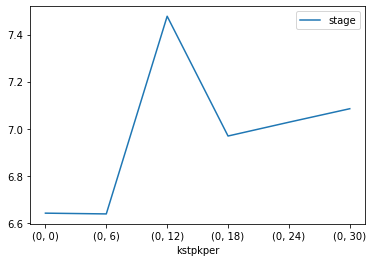

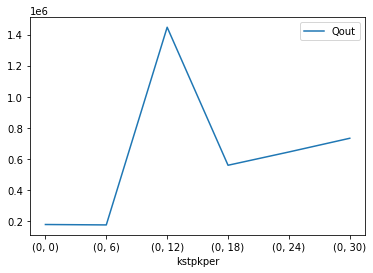

In [102]:
# Plot one location at multiple timesteps
# the last reach of the second to last segment corresponds to the cutoff at Oneto-Denier
twc = sfrout.get_dataframe()
twc = twc.loc[twc.segment ==29]
twc = twc.loc[twc.reach == 52]

twc.plot(x='kstpkper',y='stage')
twc.plot(x='kstpkper',y='Qout')
print('The diversion discharge is ', 23, 'm3/s or ', np.format_float_scientific(23*86400), 'm3/day')

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'kstpkper', 'k', 'i', 'j'],
      dtype='object')


Text(0.5, 1.0, 'Conductance')

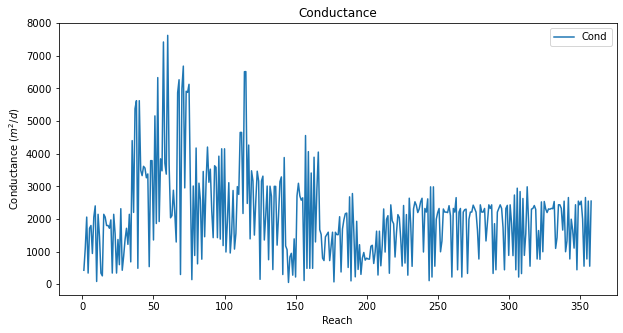

In [48]:
NSTRM = m.sfr.nstrm
sfrout = flopy.utils.SfrFile('data/MF.sfr.out')
sfrdf = sfrout.get_dataframe()
sfrdf = sfrdf[sfrdf.kstpkper == plot_step[0]]

print(sfrdf.columns)
sfrdf['xnum'] = np.arange(1,NSTRM+1)
fig, ax = plt.subplots(figsize = (10,5))
sfrdf.plot(x='xnum', y = 'Cond', ax = ax)
plt.ylabel('Conductance ($m^2/d)$')
plt.xlabel('Reach')
plt.title('Conductance')
#     plt.savefig(name +'conductance.png')


In [93]:
# grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/grid_sfr_200m_52_9/grid_sfr.shp')
sfr_sp = grid_sfr.loc[:,:]
sfr_sp['reach'] = np.arange(1,m.sfr.nstrm+1)
sfr_sp['Cond'] = sfrdf.Cond.values
sfr_sp['Qaquifer'] = sfrdf.Qaquifer.values
sfr_sp['gradient'] = sfrdf.gradient.values


fig, ax = plt.subplots(figsize = (12,12))
sfr_sp.plot(column = 'Cond',legend = True, ax = ax)
sfr_sp.plot('Qaquifer', legend = True)


ValueError: Length of values does not match length of index

## Model grid and layer review for TPROGS use

In [65]:
m.modelgrid.load_coord_info

<bound method Grid.load_coord_info of xll:639168.0879233824; yll:4229683.378775878; rotation:44.7; proj4_str:+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs; units:meters; lenuni:2>

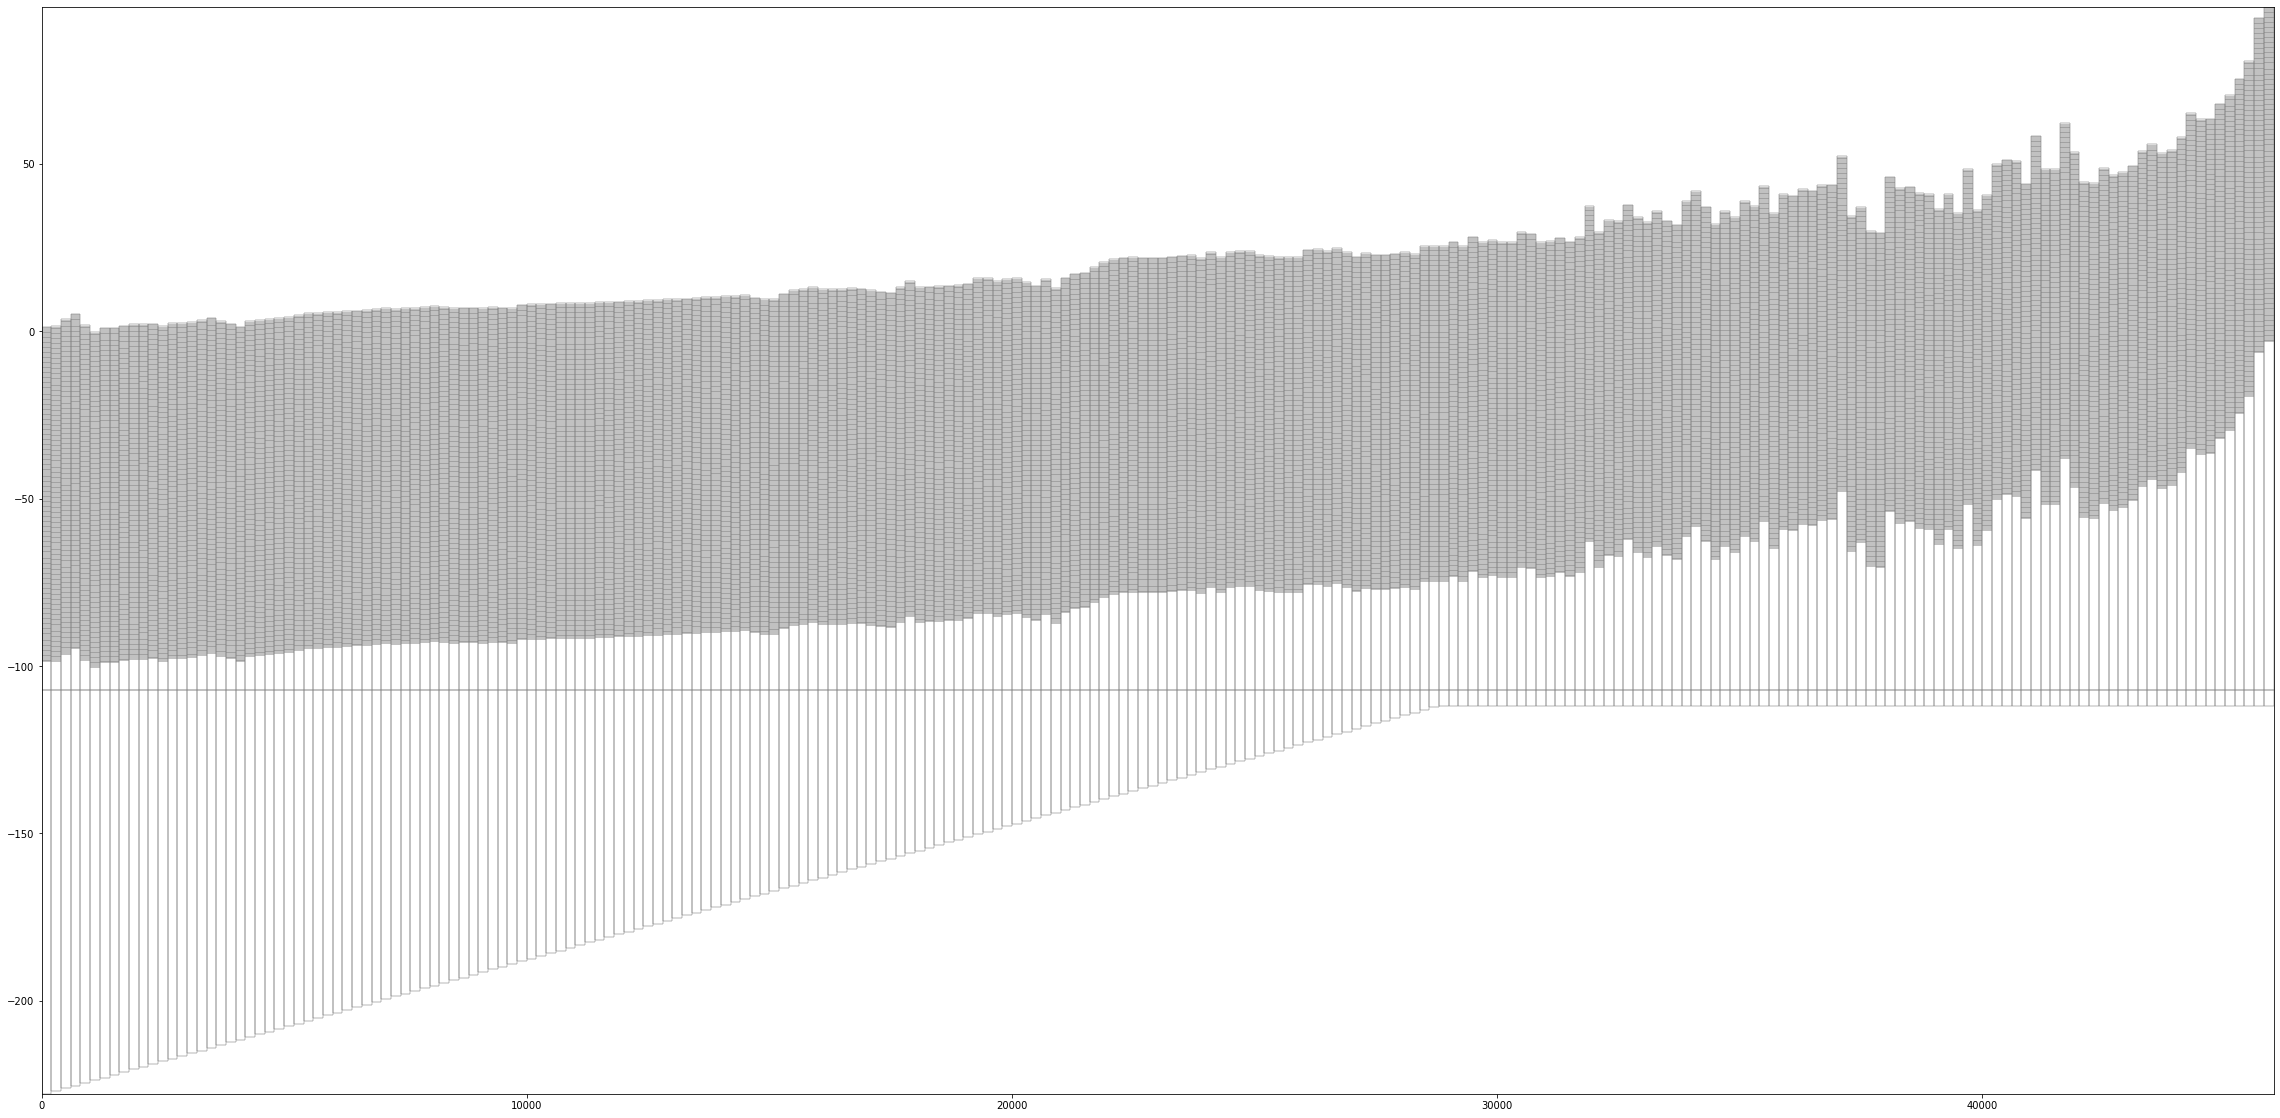

In [25]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)


rownum = 75
mcs = flopy.plot.PlotCrossSection(model=m, line={'Row' : 40})
linecollection = mcs.plot_grid(linewidth = 0.3)
ax.add_collection(linecollection)


(0, 70)

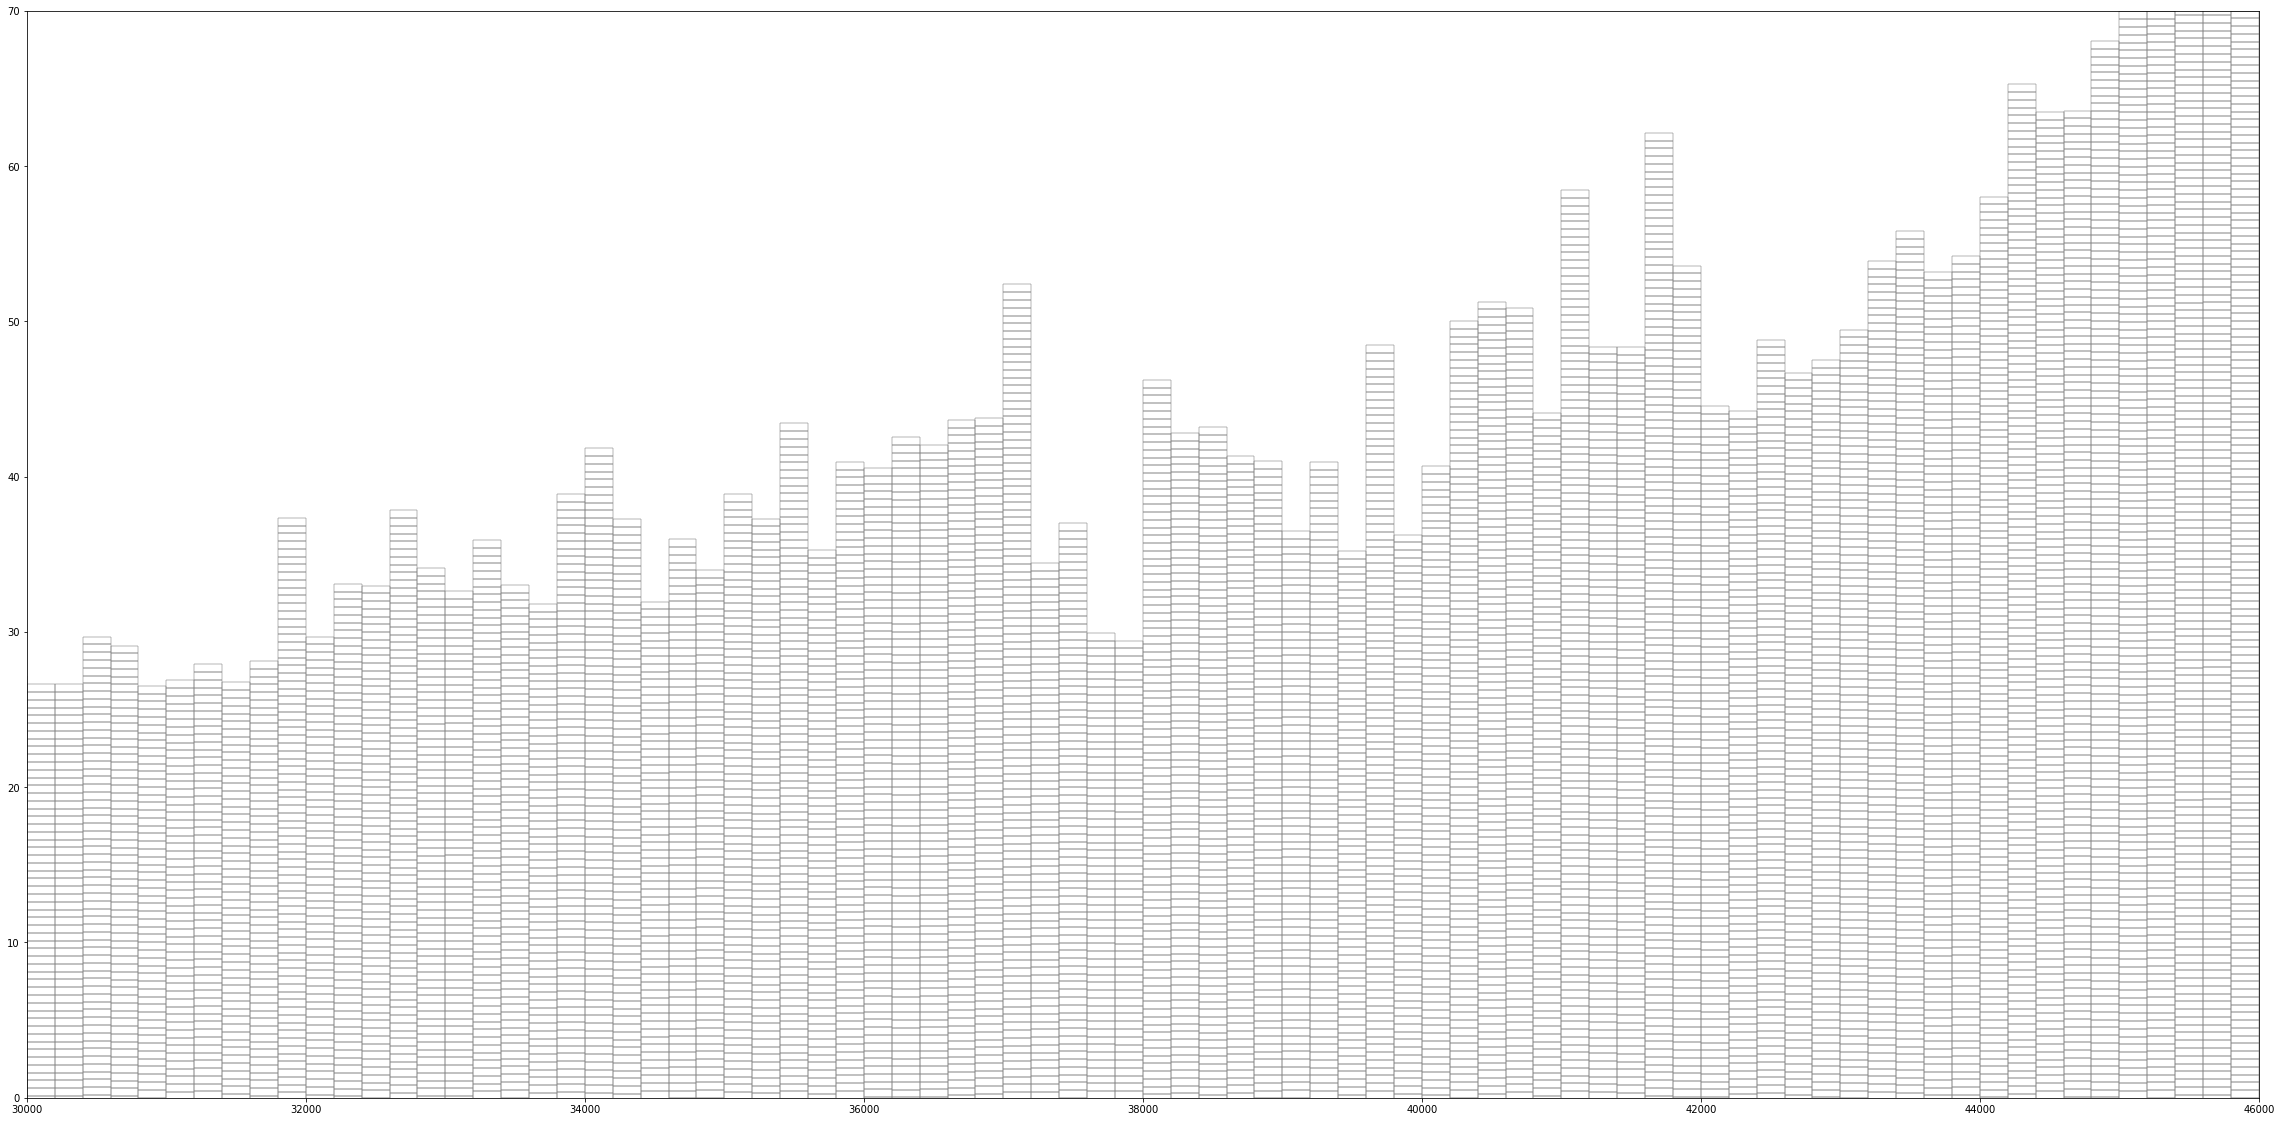

In [23]:
# head = hdobj.get_data(kstpkper = (0,0))
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)


rownum = 75
mcs = flopy.plot.PlotCrossSection(model=m, line={'Row' : 40})
linecollection = mcs.plot_grid(linewidth = 0.3)
ax.add_collection(linecollection)
ax.set_xlim(30000, 46000)
ax.set_ylim(0, 70)

# wt = mcs.plot_surface(head, masked_values = [-999.99], color = 'blue', lw = 2.5)



(20, 50)

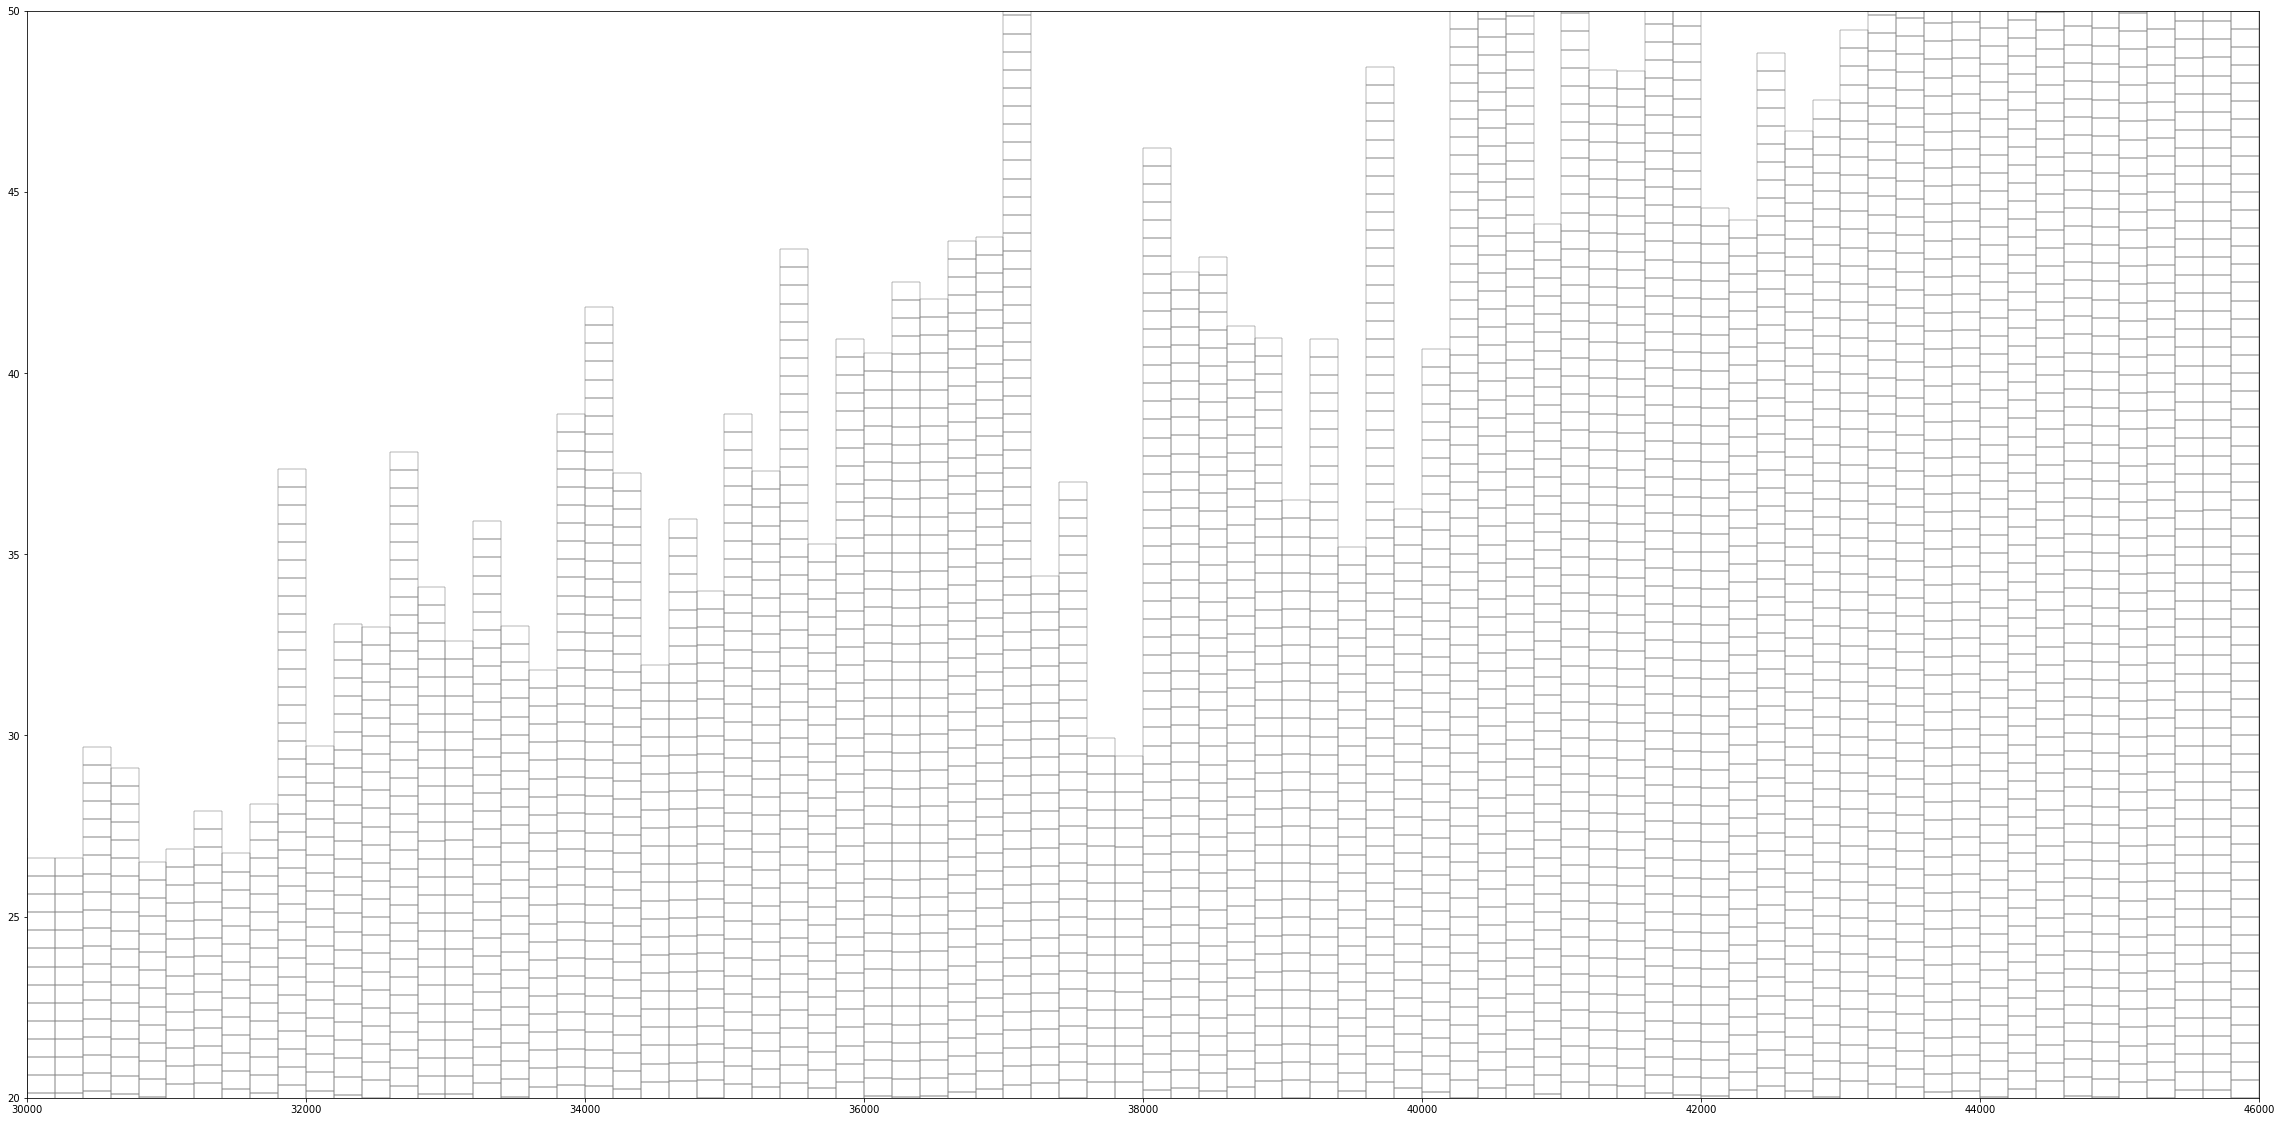

In [26]:
# head = hdobj.get_data(kstpkper = (0,0))
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)


rownum = 75
mcs = flopy.plot.PlotCrossSection(model=m, line={'Row' : 40})
linecollection = mcs.plot_grid(linewidth = 0.3)
ax.add_collection(linecollection)
ax.set_xlim(30000, 46000)
ax.set_ylim(20, 50)

# wt = mcs.plot_surface(head, masked_values = [-999.99], color = 'blue', lw = 2.5)



## Stream properties

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'kstpkper', 'k', 'i', 'j'],
      dtype='object')


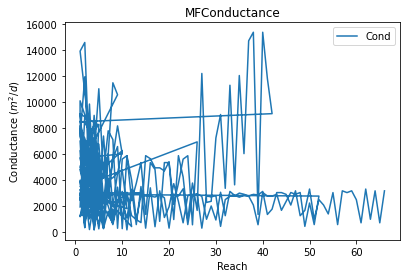

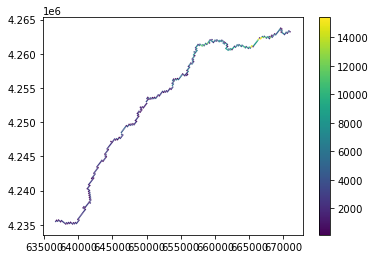

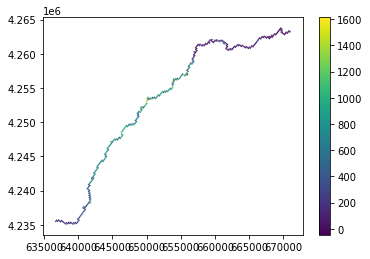

In [97]:
import matplotlib.pyplot as plt
import flopy.utils

def plot_sfr(name):
    sfrout = flopy.utils.SfrFile('data/'+name+'.sfr.out')
    sfrdf = sfrout.get_dataframe()

    sfrdf00 =sfrdf.loc[0:m.sfr.nstrm,:]
    print(sfrdf00.columns)
    sfr_sp = grid_sfr.loc[:,:]
    sfr_sp['reach'] = np.arange(1,m.sfr.nstrm+1)
    sfr_sp['Cond'] = sfrdf00.Cond.values
    sfr_sp['Qaquifer'] = sfrdf00.Qaquifer.values
    sfr_sp['gradient'] = sfrdf00.gradient.values

    sfrdf00.plot(x='reach', y = 'Cond')
    plt.ylabel('Conductance ($m^2/d)$')
    plt.xlabel('Reach')
    plt.title(name + 'Conductance')
#     plt.savefig(name +'conductance.png')
    
    sfr_sp.plot(column = 'Cond',legend = True)
    sfr_sp.plot('Qaquifer', legend = True)
plot_sfr('MF')

In [11]:
plot_sfr('MF')

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'kstpkper', 'k', 'i', 'j'],
      dtype='object')


NameError: name 'grid_sfr' is not defined

In [ ]:
# plot_sfr('SAFE')